# Interpretabilidad modelos de machine Learning

## 1. Métodos globales

In [1]:
import pandas as pd
import numpy as np
import xgboost
import mlflow
import dagshub


import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = 20, 10

dagshub.init(repo_owner='abdala9512', repo_name='dsrp-machine-learning-engineering-3', mlflow=True)

Accessing as abdala9512

Initialized MLflow to track repo "abdala9512/dsrp-machine-learning-engineering-3"

Repository abdala9512/dsrp-machine-learning-engineering-3 initialized!

In [2]:
lift_raw_data = pd.read_csv("../data/Lyftdataset.csv")
lift_raw_data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-11,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,01-01-11,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,01-01-11,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,01-01-11,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,01-01-11,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,31-12-12,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,31-12-12,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,31-12-12,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,31-12-12,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [3]:
FEATURES = ["season", "temp", "registered", "casual", "atemp", "workingday", "windspeed", "hr", "holiday"]
X, y = lift_raw_data[FEATURES], lift_raw_data["cnt"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.25)


regressor = xgboost.XGBRegressor()
regressor.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### 1.1 Feature Importance

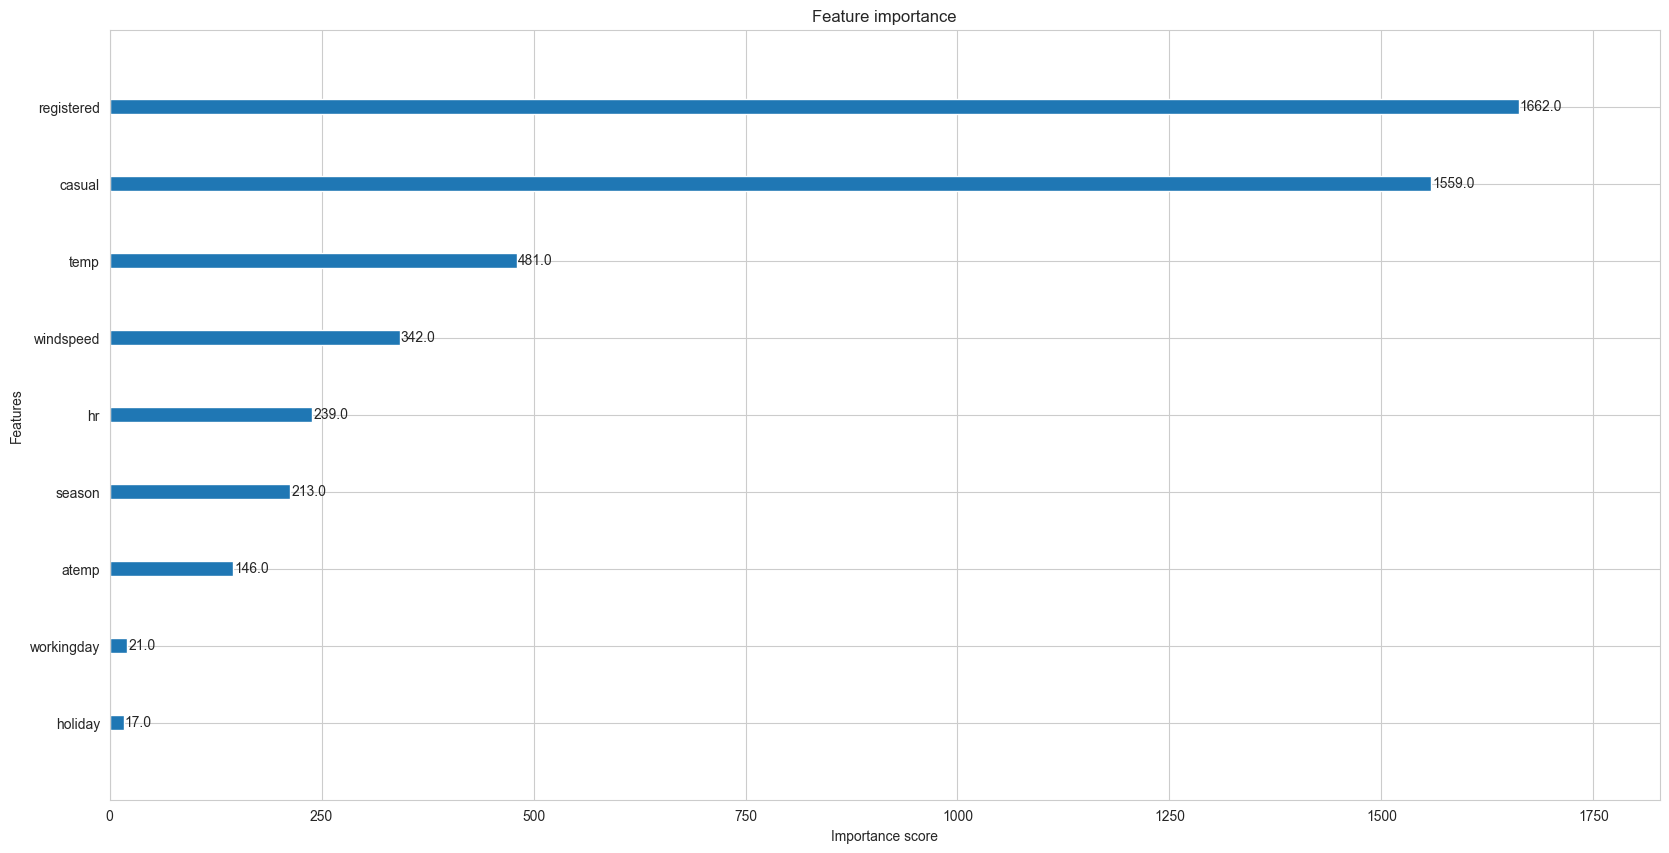

In [4]:

normalized_features_importance =  (regressor.feature_importances_ - np.min(regressor.feature_importances_)) / (np.max(regressor.feature_importances_) - np.min(regressor.feature_importances_))

importance_df = pd.DataFrame(
    {
        "Features": FEATURES,
        "scores": normalized_features_importance
    }
).sort_values(by="scores", ascending=False)

xgboost.plot_importance(regressor)

plt.savefig("fe_fig")

In [5]:
importance_df

,Features,scores
2,registered,1.000000
3,casual,0.059149
0,season,0.000195
1,temp,0.000102
7,hr,0.000091
6,windspeed,0.000077
8,holiday,0.000074
4,atemp,0.000069
5,workingday,0.000000


Text(0.5, 1.0, 'Importancia Variables - XGBoost')

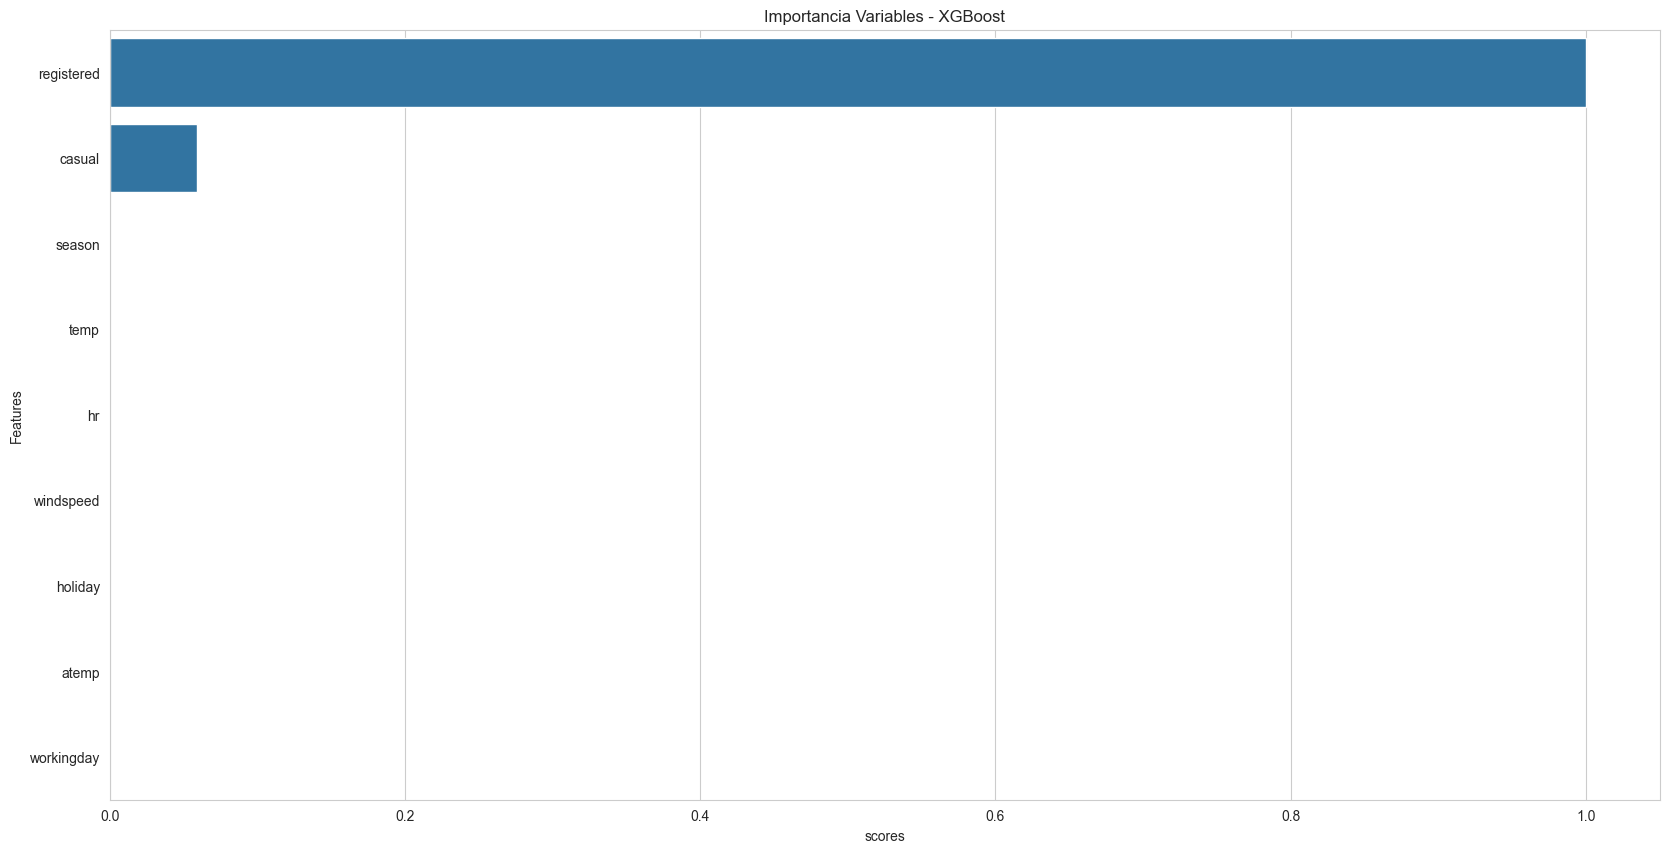

In [6]:
sns.barplot(x="scores", y="Features", data=importance_df)
plt.title("Importancia Variables - XGBoost")

### 1.2 Permutation Importance

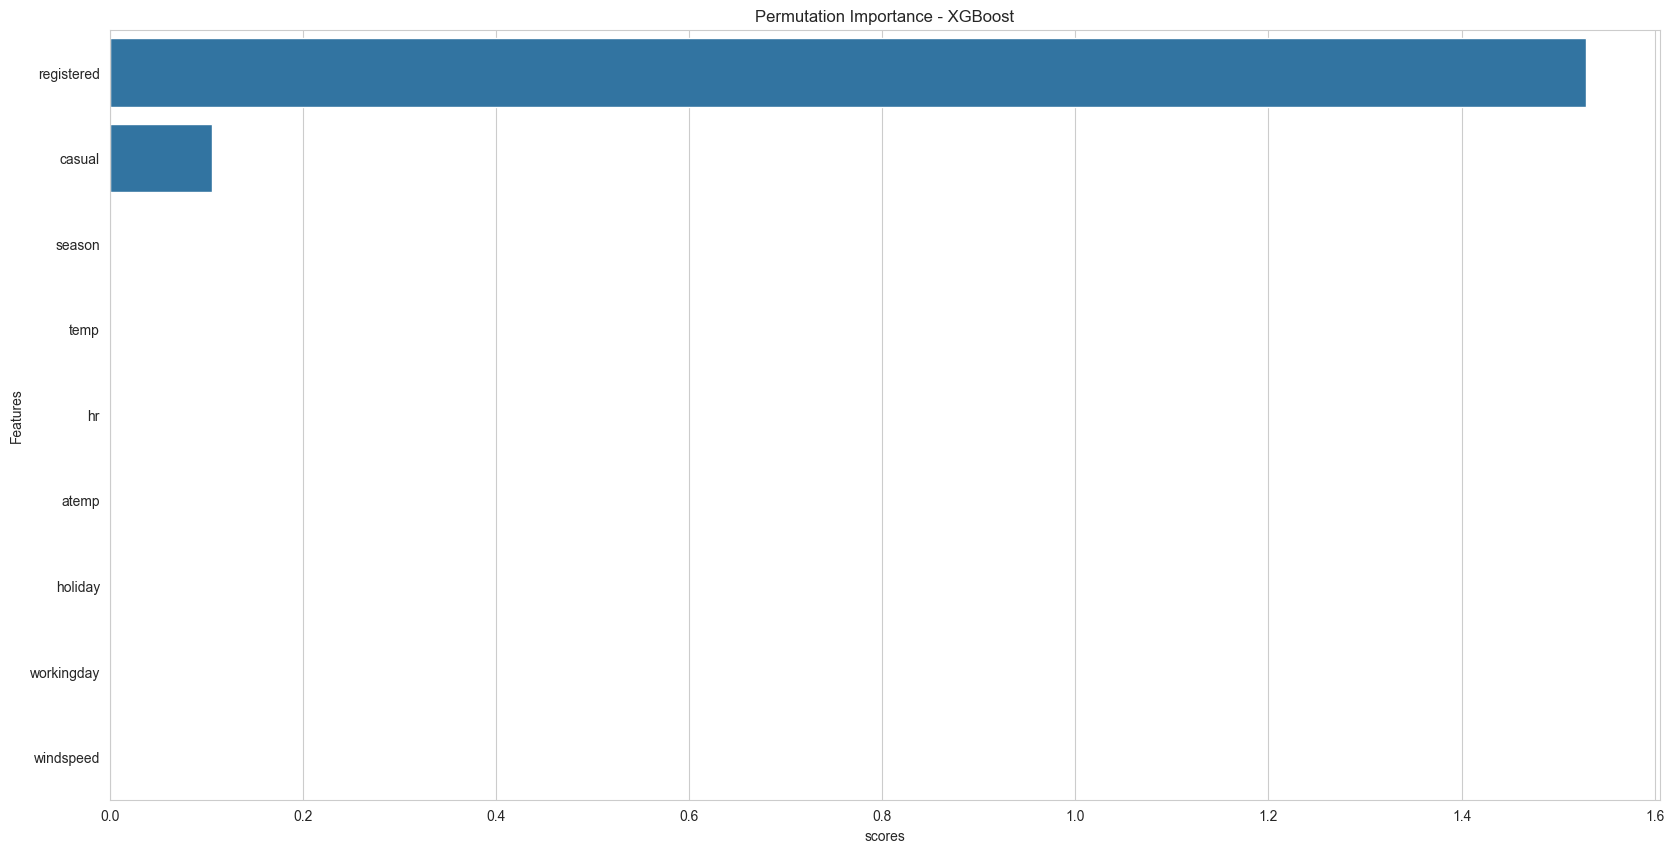

In [7]:
permutation_importance_df = pd.DataFrame(
    {
        "Features": FEATURES,
        "scores": permutation_importance(
                regressor,
                X_test,
                y_test,
                n_repeats=10,
                random_state=100
            ).importances_mean
    }
).sort_values(by="scores", ascending=False)

sns.barplot(x="scores", y="Features", data=permutation_importance_df)
plt.title("Permutation Importance - XGBoost")

plt.savefig("pe_fig")

In [8]:
permutation_importance(
                regressor,
                X_test,
                y_test,
                n_repeats=10,
                random_state=100
            )

{'importances_mean': array([ 1.71267986e-04,  6.63757324e-05,  1.52864426e+00,  1.05638307e-01,
         1.34408474e-05,  4.05311584e-07, -7.39097595e-07,  2.91824341e-05,
         2.18749046e-06]),
 'importances_std': array([3.33124083e-05, 1.11767912e-05, 2.93252975e-02, 2.22879151e-03,
        1.10805740e-05, 2.97830042e-06, 1.76866617e-05, 2.17487246e-05,
        1.25454681e-06]),
 'importances': array([[ 2.10464001e-04,  2.21908092e-04,  1.70528889e-04,
          1.75237656e-04,  1.35183334e-04,  2.16305256e-04,
          1.29401684e-04,  1.41918659e-04,  1.39117241e-04,
          1.72615051e-04],
        [ 7.08103180e-05,  6.01410866e-05,  4.70280647e-05,
          8.13007355e-05,  6.43134117e-05,  5.56111336e-05,
          6.02602959e-05,  6.46114349e-05,  7.39097595e-05,
          8.57710838e-05],
        [ 1.48865104e+00,  1.52627087e+00,  1.53490746e+00,
          1.54532361e+00,  1.52054703e+00,  1.49477065e+00,
          1.54527843e+00,  1.54377925e+00,  1.59099460e+00,
   

### 1.3 Partial Dependence Plot

/Users/miguelarquezabdala/repos/dsrp-machine-learning-engineering-3/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/miguelarquezabdala/repos/dsrp-machine-learning-engineering-3/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-

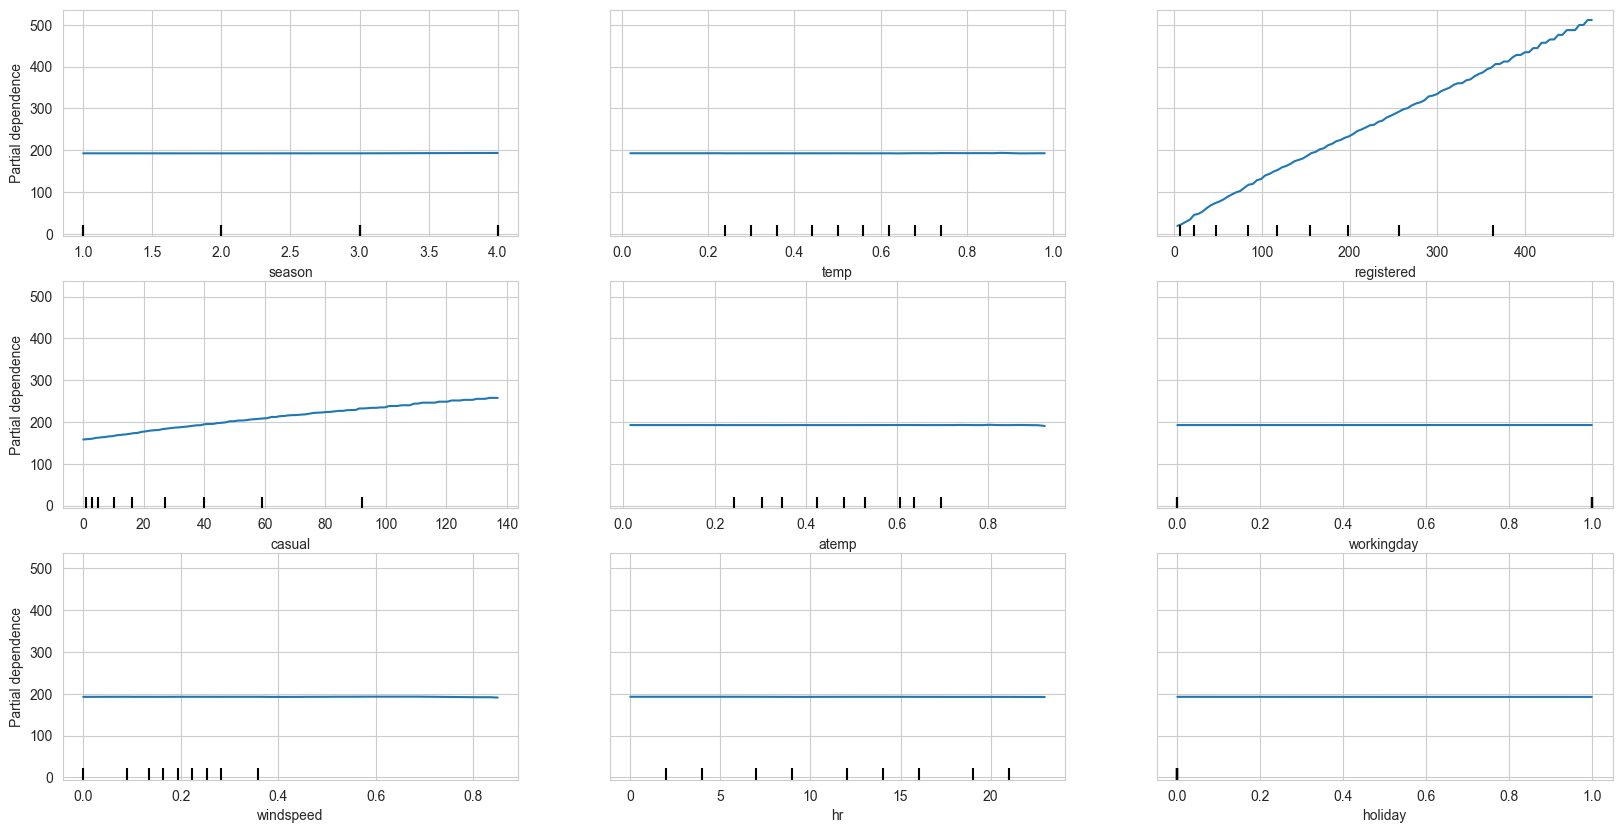

In [9]:
PartialDependenceDisplay.from_estimator(
    regressor,
    X_test,
    features=range(len(FEATURES)),
    feature_names=FEATURES,
    kind="average"
)

plt.savefig("pdp_fig")

## 2. Metodos Locales

In [10]:
import shap
import lime

/Users/miguelarquezabdala/repos/dsrp-machine-learning-engineering-3/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2.1 ICE - Individual Conditional Expectation

/Users/miguelarquezabdala/repos/dsrp-machine-learning-engineering-3/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/miguelarquezabdala/repos/dsrp-machine-learning-engineering-3/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-

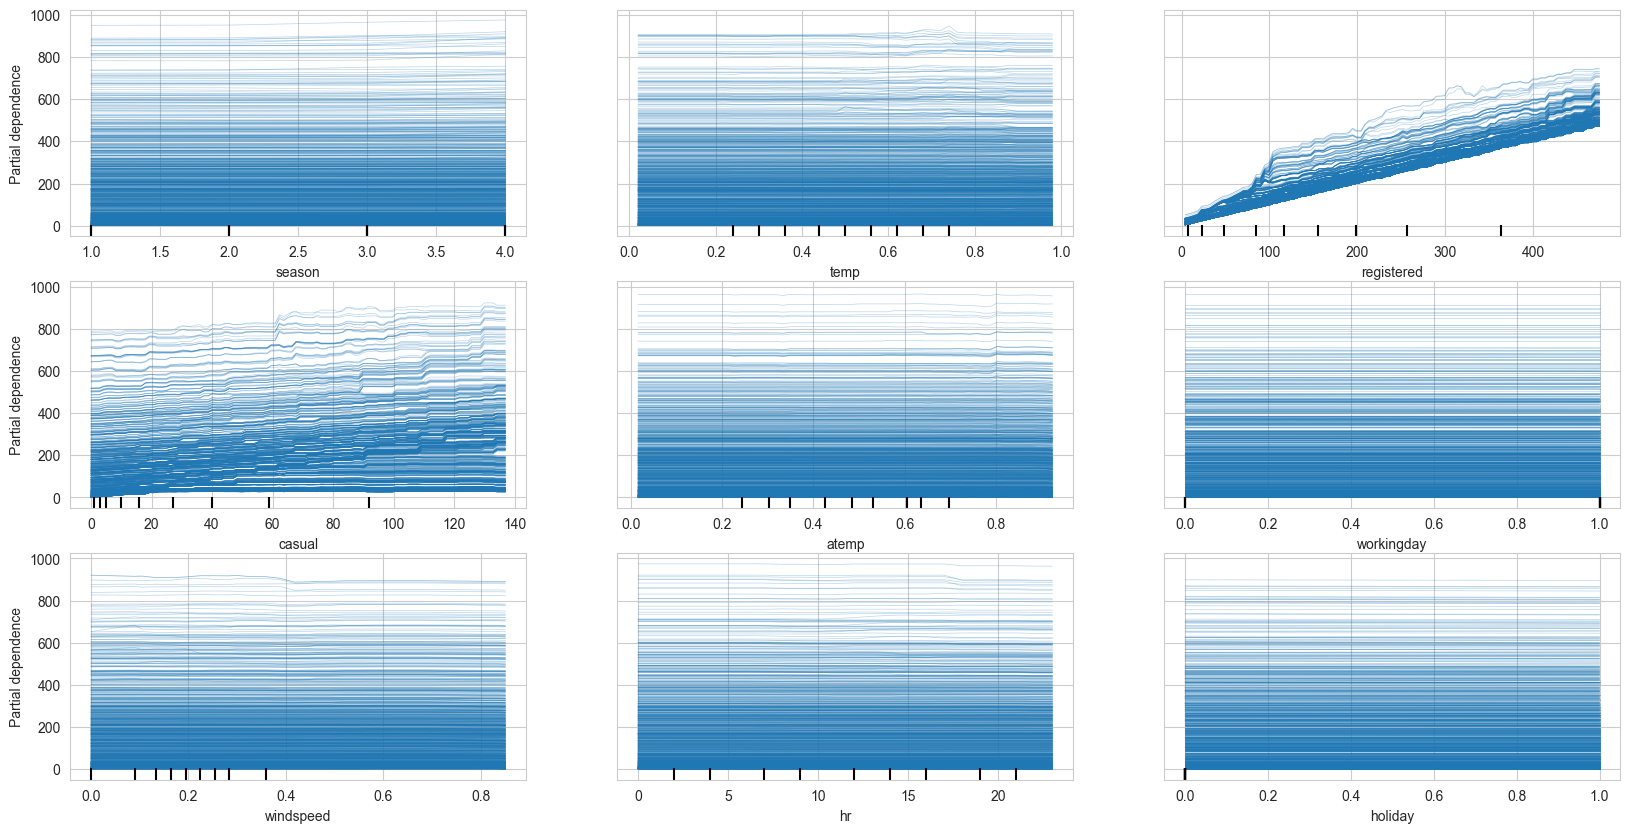

In [11]:
PartialDependenceDisplay.from_estimator(
    regressor,
    X_test,
    features=range(len(FEATURES)),
    feature_names=FEATURES,
    kind="individual"
)

plt.savefig("ice_fig")

### 2.2 LIME - Local Interpretable Model Agnostic Explanation

In [12]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=FEATURES,
    mode="regression"
)

xgboost_instance = X_test.iloc[0].values
predict_fn = lambda x: regressor.predict(x)

explanation = explainer.explain_instance(
    data_row=xgboost_instance,
    predict_fn=predict_fn,
    num_features=len(FEATURES)
)

In [13]:
explanation.show_in_notebook()
plt.savefig("lime_fig")

<Figure size 2000x1000 with 0 Axes>

### 2.3 SHAP

In [14]:
shap_explainer = shap.Explainer(regressor)
shap_values = shap_explainer.shap_values(X_test)

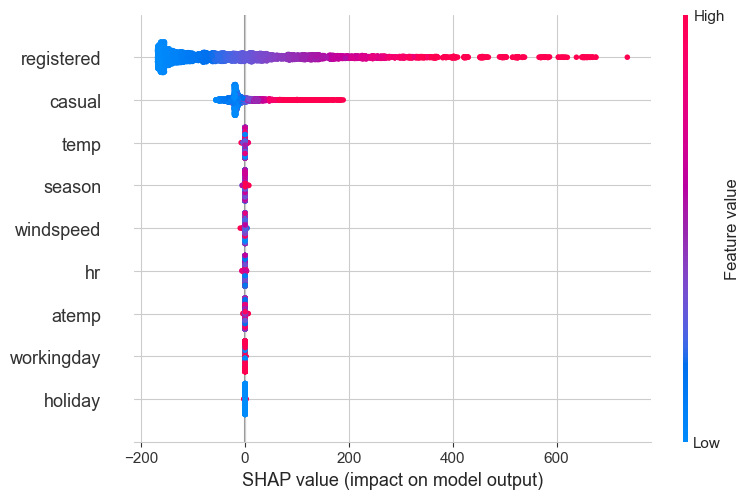

In [15]:
shap.summary_plot(shap_values=shap_values, features=X_test, feature_names=FEATURES)

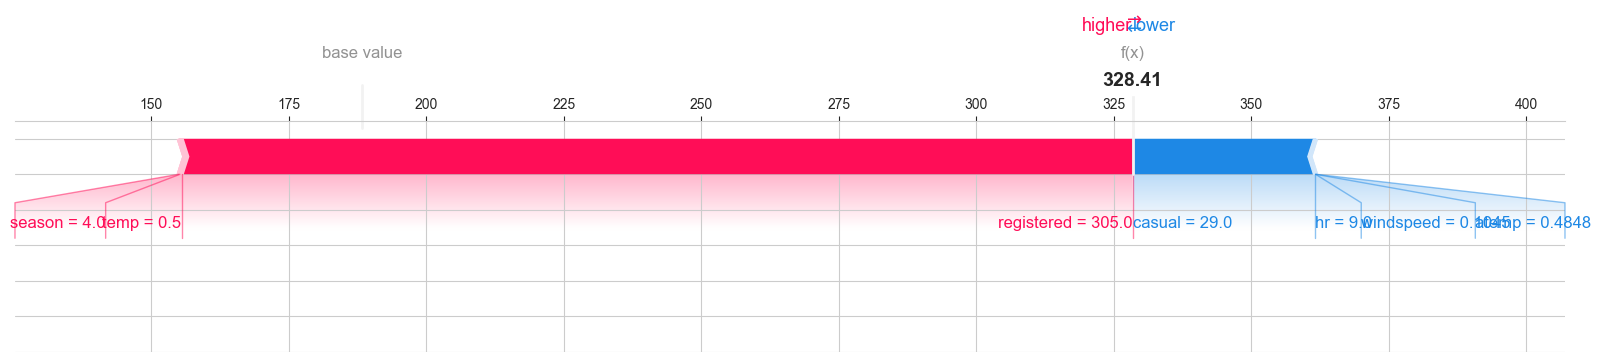

In [16]:
INSTANCE_ROW = 100

shap_plot = shap.force_plot(
    shap_explainer.expected_value,
    shap_values[INSTANCE_ROW,:],
    X_test.iloc[INSTANCE_ROW,:],
    matplotlib=True
)


In [33]:
shap.plots.force(shap_explainer.expected_value, shap_values[:500])

In [23]:
shap.save_html(plot=shap.plots.force(shap_explainer.expected_value, shap_values[:500]), out_file="shap.html")

In [ ]:
EXPERIMENT_NAME = "Interpretabilidad modelos ML"

mlflow.create_experiment(name=EXPERIMENT_NAME)
mlflow.set_experiment(EXPERIMENT_NAME)


In [30]:

with mlflow.start_run(run_name="Interpretabilidad - Clase 6") as run:

    mlflow.log_artifact("fe_fig.png")
    mlflow.log_artifact("pe_fig.png")
    mlflow.log_artifact("ice_fig.png")
    mlflow.log_artifact("pdp_fig.png")
    mlflow.log_artifact("shap.html")

🏃 View run Interpretabilidad - Clase 6 at: https://dagshub.com/abdala9512/dsrp-machine-learning-engineering-3.mlflow/#/experiments/1/runs/7e8866f38b044bdaaffff956972adbcc
🧪 View experiment at: https://dagshub.com/abdala9512/dsrp-machine-learning-engineering-3.mlflow/#/experiments/1
